In [ ]:

# นำเข้าไลบรารี
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version: 2.17.0


In [29]:
# ระบุ Path ไปยังโฟลเดอร์ dataset
dataset_dir = os.path.join(os.getcwd(), 'DatasetTrain')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #นำเข้าImageDataGeneratorจาก Keras ซึ่งเป็นคลาสที่ใช้สร้างออบเจกต์สำหรับ เตรียมข้อมูลภาพ
datagen = ImageDataGenerator(
    rescale=1./255, #ปรับค่าสีของภาพจากช่วง [0, 255] ไป [0, 1]
    validation_split=0.2, #แบ่งข้อมูลสำหรับvalidation 20%
    rotation_range=20, #ซูมภาพแบบสุ่มในช่วง 20องศา ทำให้มีมุมมองโมเดลมากขึ้น แม่นยำขึ้น
    zoom_range=0.2, #ระยะซูมภาพสุ่ม20% เพื่อความแม่นยำ
    width_shift_range=0.1, #ขยับภาพในแนวนอนแบบสุ่มได้สูงสุด 10% ของความกว้าง
    height_shift_range=0.1, #ขยับภาพในแนวตั้งแบบสุ่มได้สูงสุด 10% ของความสูง
    shear_range=0.2, #ทำการ เฉือน (shear transformation) ของภาพ
    horizontal_flip=True, #กลับภาพในแนวนอน (ซ้าย↔ขวา) แบบสุ่ม
)

(-0.5, 149.5, 149.5, -0.5)

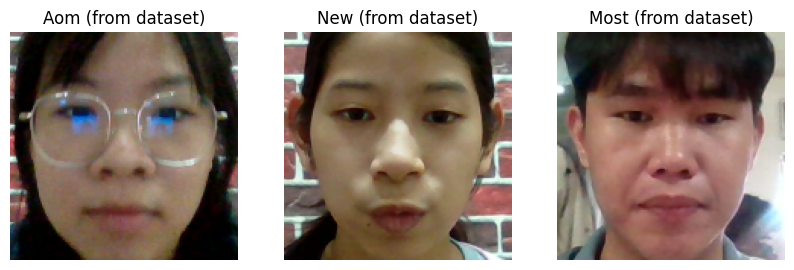

In [73]:


# สร้างพื้นที่สำหรับวาดภาพขนาด 2x2
plt.figure(figsize=(10, 8))

# --- 1. แสดงรูป Aom จากชุด dataset ---
plt.subplot(2, 3, 1)
# เลือกโฟลเดอร์ dataset/Aom และสุ่มชื่อไฟล์รูปภาพมา 1 ไฟล์
Aom_dataset_path = os.path.join(dataset_dir, 'Aom')
random_Aom = random.choice(os.listdir(Aom_dataset_path))

# อ่านและแสดงรูปภาพ
img = mpimg.imread(os.path.join(Aom_dataset_path, random_Aom))
plt.imshow(img)
plt.title('Aom (from dataset)')
plt.axis('off')

# --- 2. แสดงรูป New จากชุด dataset ---
plt.subplot(2, 3, 2)
# เลือกโฟลเดอร์ dataset/New และสุ่มชื่อไฟล์รูปภาพมา 1 ไฟล์
New_dataset_path = os.path.join(dataset_dir, 'New')
random_New = random.choice(os.listdir(New_dataset_path))
# อ่านและแสดงรูปภาพ
img = mpimg.imread(os.path.join(New_dataset_path, random_New))
plt.imshow(img)
plt.title('New (from dataset)')
plt.axis('off')

# --- 3. แสดงรูป Most จากชุด dataset ---
plt.subplot(2, 3, 3)
# เลือกโฟลเดอร์ dataset/Most และสุ่มชื่อไฟล์รูปภาพมา 1 ไฟล์
Most_dataset_path = os.path.join(dataset_dir, 'Most')
random_Most = random.choice(os.listdir(Most_dataset_path))

# อ่านและแสดงรูปภาพ
img = mpimg.imread(os.path.join(Most_dataset_path, random_Most))
plt.imshow(img)
plt.title('Most (from dataset)')
plt.axis('off')

In [ ]:
# กำหนดค่าพื้นฐาน
BATCH_SIZE = 32
IMG_SIZE = 150 # ขนาดรูปภาพที่ต้องการ (กว้าง x สูง)


#datagen.flow_from_directory เพื่อโหลดภาพจากโฟลเดอร์ และเตรียมให้พร้อมสำหรับการเทรนในรูปแบบ batch
# สร้างชุดข้อมูลสำหรับฝึก (Train)
train_dataset = datagen.flow_from_directory(
    dataset_dir,#path folder ของข้อมูลที่จะนำไปเทรน
    target_size=(150, 150),#กำหนดขนาดภาพ resize ให้มีขนาด 150×150 pixel ก่อนนำเข้าโมเดล
    batch_size=32, #แต่ละรอบจะส่งภาพเข้าระบบทีละ 32 ภาพ เพื่อไม่ให้กินหน่วยความจำมากเกินไป
    class_mode='categorical', #ระบุว่า label ของข้อมูลเป็นแบบ “หลายคลาส” (multi-class)
    subset='training'#ใช้เฉพาะข้อมูลส่วนที่เป็น training
)

val_dataset = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation' #ใช้เฉพาะข้อมูลส่วนที่เป็น validation
)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),#กำหนดขนาดของภาพที่จะป้อนเข้าโมเดล 3 คือ RGB
    include_top=False,#→ ไม่เอาส่วน “หัวโมเดล” (fully connected layers) เพราะเราจะเพิ่ม “head” ของเราที่จำแนกเฉพาะคลาสใน dataset ของเราเอง
    weights='imagenet' #โหลดน้ำหนักที่เทรนมาจาก ImageNet มาใช้ เพื่อใช้ประโยชน์จาก feature ที่โมเดลเรียนรู้ไว้แล้ว(transfer learning)
)

base_model.trainable = False  # ไม่เทรนชั้น base

# แสดงชื่อคลาสที่เจอ ('Aom','Most','New')
class_names = list(train_dataset.class_indices.keys())
print("คลาสที่พบ:", class_names)

Found 2424 images belonging to 4 classes.
Found 603 images belonging to 4 classes.


C:\Users\Lnwmo\AppData\Local\Temp\ipykernel_2348\452533646.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


คลาสที่พบ: ['Aom', 'Most', 'New', 'Unknow']


In [74]:
# สร้างโมเดลแบบลำดับชั้น (Sequential)
# Sequential: คือการบอกว่าจะสร้างโมเดลโดยการนำแต่ละชั้น (layer) มาต่อกันเป็นลำดับ
model = tf.keras.Sequential([ 
    base_model, #คือโมเดลฐาน ที่ถูกโหลดมาจากโมเดลสำเร็จรูป (pretrained model)
   tf.keras.layers.GlobalAveragePooling2D(), #ลดมิติของ Feature Map ที่ได้จาก base_model
    tf.keras.layers.Flatten(),#แปลงข้อมูลจาก2D,3D เป็น 1D
    tf.keras.layers.Dense(128, activation='relu'), #ใช้reluปรับ
    tf.keras.layers.Dropout(0.3),#ปิดการทำงานของบาง neuron แบบสุ่ม 30% (0.3) ขณะเทรน ป้องกันoverfitting
    tf.keras.layers.Dense(3, activation='softmax')  # จำแนก3class ใช้ฟังก์ชัน Softmax เพื่อให้ผลลัพธ์ออกมาเป็น ความน่าจะเป็นรวมกันได้ 1
])

In [ ]:
# optimizer (วิธีปรับปรุงโมเดล), loss (วิธีวัดความผิดพลาด) และ metrics (การวัดผล เช่น accuracy หรือความแม่นยำ)
model.compile(optimizer='adam', #อัลกอริทึมปรับน้ำหนักอัตโนมัติ ที่ได้รับความนิยมมากที่สุดใน deep learning
              loss='categorical_crossentropy', #ใช้ในกรณีที่มี หลายคลาส
              metrics=['accuracy'])

In [ ]:
EPOCHS = 10 # จำนวนรอบในการฝึก

# เริ่มฝึกโมเดล
history = model.fit(
    train_dataset,#ชุดข้อมุลที่ฝึก
    validation_data=val_dataset,#ชุดข้อมุลที่จะนำมาvalidation
    epochs=EPOCHS,#จำนวนรอบฝึก
)

print("ฝึกโมเดลเสร็จสิ้น!")

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 423ms/step - accuracy: 0.7827 - loss: 0.6039 - val_accuracy: 0.9718 - val_loss: 0.0882
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 397ms/step - accuracy: 0.9721 - loss: 0.0924 - val_accuracy: 0.9818 - val_loss: 0.0782
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 399ms/step - accuracy: 0.9809 - loss: 0.0558 - val_accuracy: 0.9768 - val_loss: 0.0630
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.9830 - loss: 0.0474 - val_accuracy: 0.9818 - val_loss: 0.0402
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9912 - loss: 0.0306 - val_accuracy: 0.9818 - val_loss: 0.0486
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9923 - loss: 0.0284 - val_accuracy: 0.9818 - val_loss: 0.0391
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9954 - loss: 0.0202 - val_accuracy: 0.9701 - val_loss: 0.0970
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 413ms/step - accuracy: 0.9905 - loss: 0.0255 - val_accu

In [39]:
loss, accuracy = model.evaluate(val_dataset)
print(f"\nความแม่นยำของโมเดล: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.9776 - loss: 0.0964

ความแม่นยำของโมเดล: 98.34%


In [ ]:
#FaceSecurity
import cv2 #ใช้ OpenCV สำหรับเปิดกล้อง, ตรวจจับใบหน้า และแสดงภาพ

# รายชื่อคลาส
class_names = ['Aom', 'Most', 'New']


# โหลดตัวตรวจจับใบหน้า (ใช้ Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#ใช้ Haar Cascade ที่มากับ OpenCV สำหรับตรวจจับใบหน้าคน

cap = cv2.VideoCapture(0) #เปิดกล้องหลักของเครื่อง
print("กล้องพร้อมใช้งาน กด 'Q' เพื่อออก")

while True:
    ret, frame = cap.read() #อ่านภาพทีละเฟรมจากกล้อง
    if not ret: #ถ้าอ่านไม่ได้ออกจาก loop
        break
    #face detection แปลงเป็นgray scale จะตรวจจับง่ายกว่า
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #ตรวจจับใบหน้าในภาพ (gray,scalefactorคือปรับขนาดเพื่อค้นหาใบหน้า,minNeighborsยิ่งมาก ยิ่งแม่น (แต่ตรวจจับช้าขึ้น),minsizeคือขนาดขั้นต่ำของหน้า)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(100, 100))

    if len(faces) > 0:
        for (x, y, w, h) in faces:
            face_img = frame[y:y+h, x:x+w] #ครอปเฉพาะส่วนใบหน้าออกมาจากภาพ
            face_img = cv2.resize(face_img, (150, 150)) / 255.0 #ปรับขนาดภาพให้ตรงกับ input ของโมเดล (150×150) จากนั้นnormalizedให้อยู่ช่วง[0-1]
            face_img = np.expand_dims(face_img, axis=0) #เพิ่มมิติ batch (จาก (150,150,3) → (1,150,150,3)) เพื่อป้อนให้โมเดล

            #ทำนายผลเฉพาะหน้า
            preds = model.predict(face_img)
            idx = np.argmax(preds)#ค่าที่ได้มากสุดตำแหน่ง0,1,2
            conf = np.max(preds)#ค่าความเชื่อมั่นที่มากที่สุด
            if conf >= 0.8: #ถ้ามากกว่าค่าความเชื่อมั่นที่0.8
                label = f"Detect:  {class_names[idx]} ({conf*100:.1f}%)" #พบเจอใบหน้าใคร มั่นใจกี่%
                color = (0, 255, 0) #สีเขียว
            else:
                label = f"Unknow ({conf*100:.1f}%)" #พบเจอหน้าแต่ไม่รู้จัก
                color = (0, 0, 255) #สีแดง

            # วาดหน้า
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2) #วาดสี่เหลี่ยมเป็นกรอบตรงหน้า
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2) #ใส่ข้อความ
    else:
        # ถ้าไม่เจอใบหน้า
        cv2.putText(frame, "No face detected", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow("FaceSecurity", frame) #ชื่อtitle program
    if cv2.waitKey(1) & 0xFF == ord('q'): #กด Q ออกจากโปรแกรม
        break

#หยุดการทำงานของกล้อง
cap.release()
cv2.destroyAllWindows()
print("ปิดกล้องเรียบร้อย")


📷 กล้องพร้อมใช้งาน กด 'q' เพื่อออก
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━